# Imports

In [1]:
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import h5py

import pandas as pd
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from openTSNE import TSNE as opTSNE

from skimage.color import lab2rgb , rgb2lab

import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans

from scipy.stats import hypergeom,fisher_exact



from sklearn.mixture import GaussianMixture 
# from lifelines import KaplanMeierFitter

import copy
import time



# Functions

In [2]:
def SampleZoomIn(SampleID , PixelSampleID ,padding_factor = 1):
    specific_index = SampleID
    mask = (PixelSampleID == specific_index) 
    label_indices = np.where(mask == True)

    zoomed_height_max = max(label_indices[0]) + padding_factor
    zoomed_height_min = min(label_indices[0]) - padding_factor
    zoomed_width_max = max(label_indices[1]) + padding_factor
    zoomed_width_min = min(label_indices[1]) - padding_factor

    if zoomed_height_max > height:
        zoomed_height_max= height

    if zoomed_height_min < 0:
        zoomed_height_min= 0

    if zoomed_width_max > width:
        zoomed_width_max= width

    if zoomed_width_min < 0:
        zoomed_width_min= 0
        
    return zoomed_height_max , zoomed_height_min , zoomed_width_max, zoomed_width_min

In [3]:
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [4]:
def CreateColorMap(NumberofColors , colorsArray ):
    cmap = LinearSegmentedColormap.from_list('cmap', colorsArray, N=NumberofColors)
    return cmap

In [5]:
def CreateColorMap_Continuous(NumberofColors , colorsArray ):
    cvals = np.arange(0,NumberofColors-1)
    colors = colorsArray
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    
    return cmap

# Reading Breast Data

In [6]:
h5 = h5py.File('breastData.mat', 'r')


HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube = h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID = h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  
print(list(h5.keys()))
z = h5.get('z')[:]
print(z)
h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')
height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 
indices_of_background = np.where(flattened_pixel_to_sample_ID == -1)
sample_only_data = np.delete(flattened_MSI_data_cube, indices_of_background[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_of_background[0] , axis=0)
# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
sample_only_scaled_data = scaler.fit_transform(sample_only_data) 


['#refs#', '#subsystem#', 'Clinical_data', 'HE_image', 'MSI_data_cube', 'goodlist', 'peak_list', 'pixel_to_sample_ID', 'x', 'y', 'z']
[[62.]]


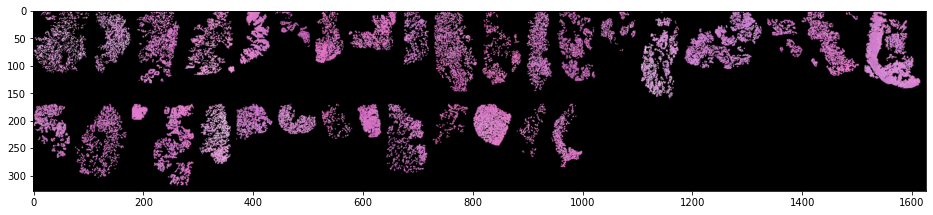

In [7]:
plt.figure(figsize=(16,10))
plt.imshow(HE_image)
plt.show()

# PCA 

In [8]:
pca = PCA(n_components=8)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.17345186 0.105074   0.06409267 0.0596135  0.05411807 0.04949256
 0.04291978 0.03653113]


In [9]:
sample_only_scaled_data.shape

(48426, 62)

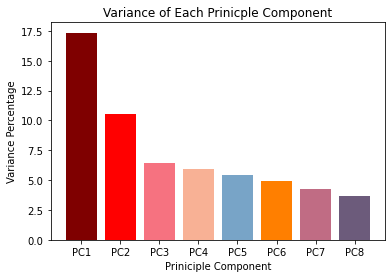

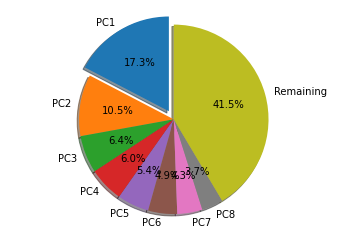

Variance Represented by PCA = 58.53 %


In [10]:
PCA=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"]

COLORS =["#7f0000","#ff0000","#F67280","#F8B195", "#78a4c7","#ff7f00","#C06C84","#6C5B7B" ]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

# Pie chart
labels = "PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8", "Remaining"
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] ,variance[5],variance[6],variance[7] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] +variance[5]+variance[6]+variance[7]) ]
explode = (0.1, 0, 0, 0, 0, 0,0,0,0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4]+variance[5]+variance[6]+variance[7])*100 , 2) ) +' %')

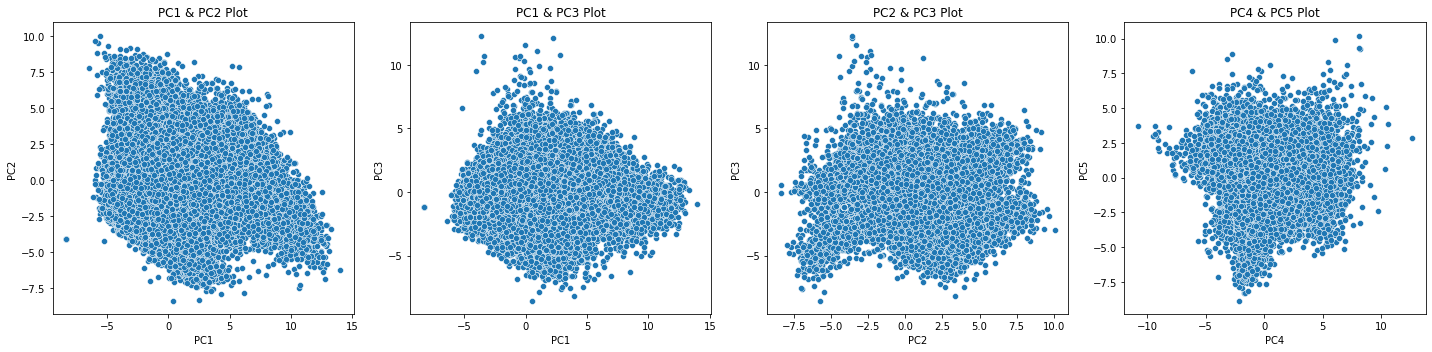

Text(0.5, 0.92, 'PCA 3D')

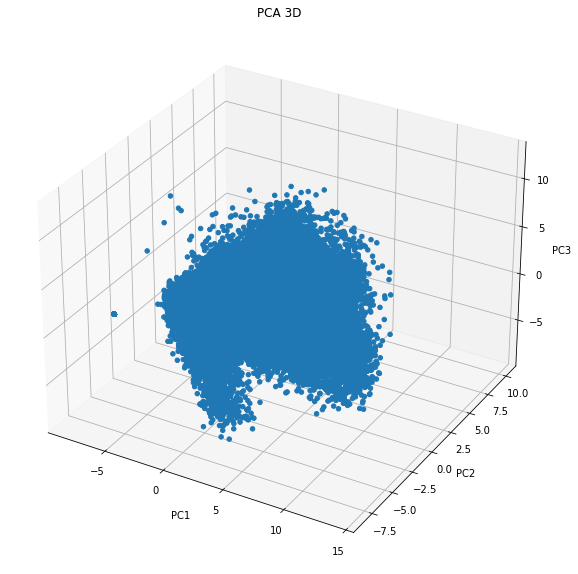

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")
sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")
sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

# TSNE

In [12]:
# Old Breast Cancer TSNE Settings

# time_start = time.time()
# tsne = opTSNE(
#     n_components = 3,
#     perplexity = 30,
#     learning_rate = 200,
#     initialization  = 'pca',
#     random_state = 0,
#     early_exaggeration = 12,
#     n_iter = 1000,
#     # verbose=False,
#     early_exaggeration_iter = 250,
#     # early_exaggeration = 10,
#     # n_iter = 700,
#     # initialization = 'pca',
#     # initial_momentum = 0.5,
#     # final_momentum = 0.8,
#     metric="euclidean",
#     # n_jobs=-1,
#     # random_state=0,
#     negative_gradient_method = 'barnes-hut',
#     verbose=True,
# )
# %time tsne_results_op = tsne.fit(sample_only_scaled_data)

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# np.save('op_tSNE_Results_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results)

In [13]:
# tSNE Model , Run once and save results in numpy array to be used later
'''
time_start = time.time()
tsne_results_op = TSNE(n_components=3,
            perplexity = 50,
            learning_rate = 200,
            init = 'random',
            random_state = 0,
            early_exaggeration = 12,
            n_iter = 1500,
            verbose=True,
            ).fit_transform(sample_only_scaled_data)



print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''


"\ntime_start = time.time()\ntsne_results_op = TSNE(n_components=3,\n            perplexity = 50,\n            learning_rate = 200,\n            init = 'random',\n            random_state = 0,\n            early_exaggeration = 12,\n            n_iter = 1500,\n            verbose=True,\n            ).fit_transform(sample_only_scaled_data)\n\n\n\nprint('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))\n"

In [14]:
# tsne_results_op = np.load('op_tSNE_Results_per30_lr200_earlyexagiter450_earlyexag10_iter700_intialization_PCATime_493.8574388027191_seconds.npy')
# tsne_results_op = np.load('op_tSNE_Results_per30_lr200_earlyexagiter250_earlyexag12_iter1000_PCATime_1808.5516831874847_seconds.npy')
tsne_results_op = np.load('tSNE_Breast_Results_default_Time_2366.2736546993256_seconds.npy')

In [15]:
tsne_df = pd.DataFrame(data=tsne_results_op[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = sample_ID_pixels
tsne_df['L_Component'] = tsne_results_op[:,0]
tsne_df['A_Component'] = tsne_results_op[:,1]
tsne_df['B_Component'] = tsne_results_op[:,2]

In [16]:
LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A, B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)

C:\Users\omars\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2190 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


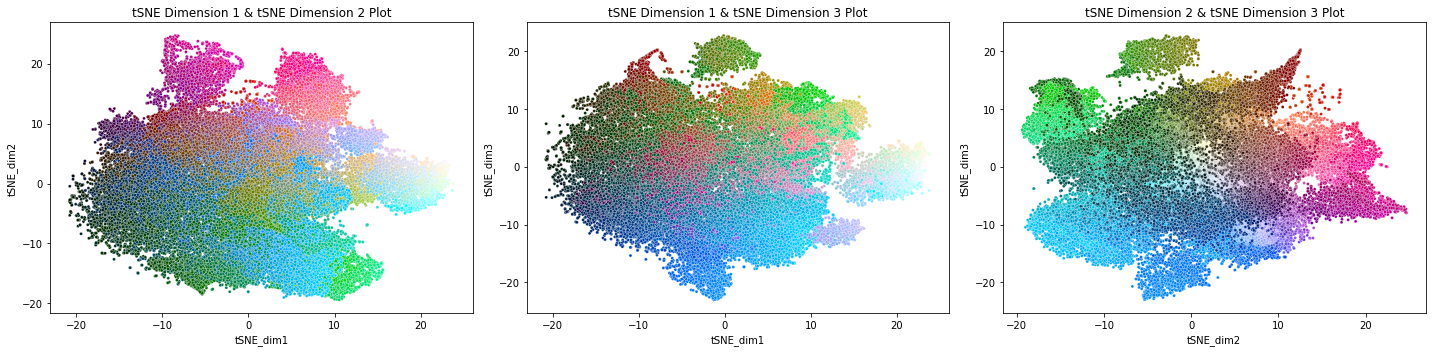

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()


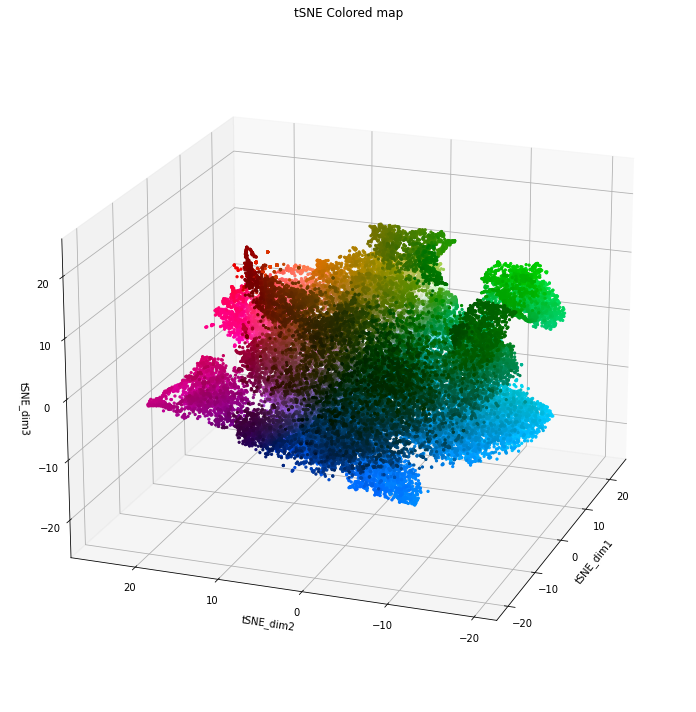

In [18]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'],
    zs= tsne_df['tSNE_dim3'],
    c = RGB_colors,
    s = 5,
    alpha = 1,
)
# ax.set_xlim(-40,40)
# ax.set_ylim(-40,40)
# ax.set_zlim(-40,40)
ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Colored map")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


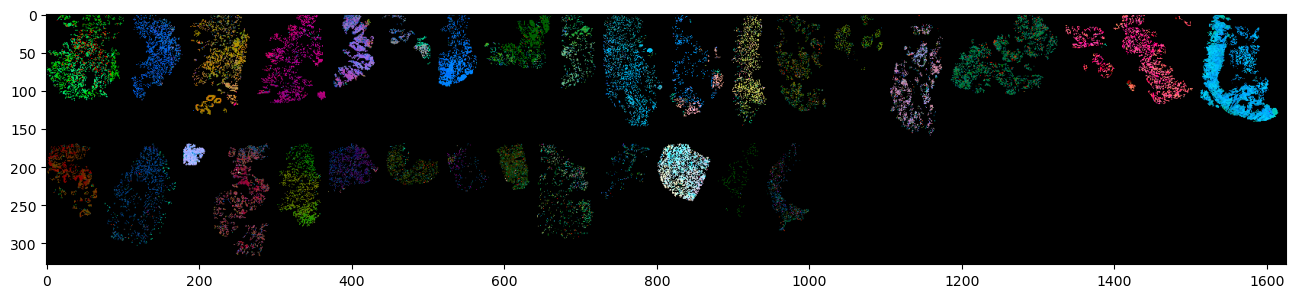

In [19]:
indices_edit = np.where(pixel_to_sample_ID != -1)
tsne_image = np.zeros( (height,width,3) )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    tsne_image[i][j][0] = RGB_colors[increment][0]
    tsne_image[i][j][1] = RGB_colors[increment][1]
    tsne_image[i][j][2] = RGB_colors[increment][2]
    increment += 1

plt.figure(figsize=(16, 8), dpi=100)
plt.imshow(tsne_image)


# Kmeans 

In [20]:
kmeans = KMeans(n_clusters=8, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)
kmeans_7 = KMeans(n_clusters=7, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)
kmeans_6 = KMeans(n_clusters=6, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)
kmeans_5 = KMeans(n_clusters=5, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)

#kmeans_9 = KMeans(n_clusters=9, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)



In [21]:
indices_edit = np.where(pixel_to_sample_ID != -1)
KMeans_image = np.full( (height,width),-1 )
KMeans_image_6 = np.full( (height,width),-1 )
KMeans_image_7 = np.full( (height,width),-1 )
KMeans_image_5 = np.full( (height,width),-1 )

increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image[i][j] = kmeans.labels_[increment]
    
    increment += 1

increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_6[i][j] = kmeans_6.labels_[increment]
    
    increment += 1
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_7[i][j] = kmeans_7.labels_[increment]
    
    increment += 1
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_5[i][j] = kmeans_5.labels_[increment]
    
    increment += 1
increment = 0

# Gaussian Mixture Model

In [22]:
gmm = GaussianMixture(n_components=8,
                      max_iter=1500,
                      n_init=10,
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(tsne_results_op)


In [23]:
indices_edit = np.where(pixel_to_sample_ID != -1)
gaussian_image = np.full((height, width), -1)

increment = 0
for i, j in zip(indices_edit[0], indices_edit[1]):
    gaussian_image[i][j] = gmm[increment]
    increment += 1


# Whole image Results

In [24]:
# colorsarray = [ "black" , "royalblue" , , "aqua" , "orangered" , "yellow",,"sandybrown","red" ] 
# colorsarray=["black","#80B1D3","#FF7F0E","#2CA02C","#B5CF6B","#9467BD","#E7CB94","#BCBD22","#FFD92F"]
# colorsarray=['#000000','powderblue','magenta', 'teal', 'yellow', 'blue', 'orange',"lime","crimson"]
# colorsarray8 = [ "black" , "magenta" , "#007fff", "#00ffff" , "#7fff7f" , "#ffff00","#ff7f00","#ff0000","#7f0000" ]
colorarray8=[ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000","#ff7f00"]
colorsarray7 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000"]
colorsarray6 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo"]
colorsarray5 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia"]

colorsarrayTSNE = ["olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000","#ff7f00"]
colorsarray_5_TSNE = ["olivedrab","gold","darkturquoise", "wheat","fuchsia"]

cmap8 = CreateColorMap(9,colorarray8)
cmapTSNE= CreateColorMap(8,colorsarrayTSNE)

cmap7 = CreateColorMap(8,colorsarray7)
cmap6 = CreateColorMap(7,colorsarray6)

cmap5 = CreateColorMap(6,colorsarray5)
cmap5_TSNE = CreateColorMap(5,colorsarray_5_TSNE)

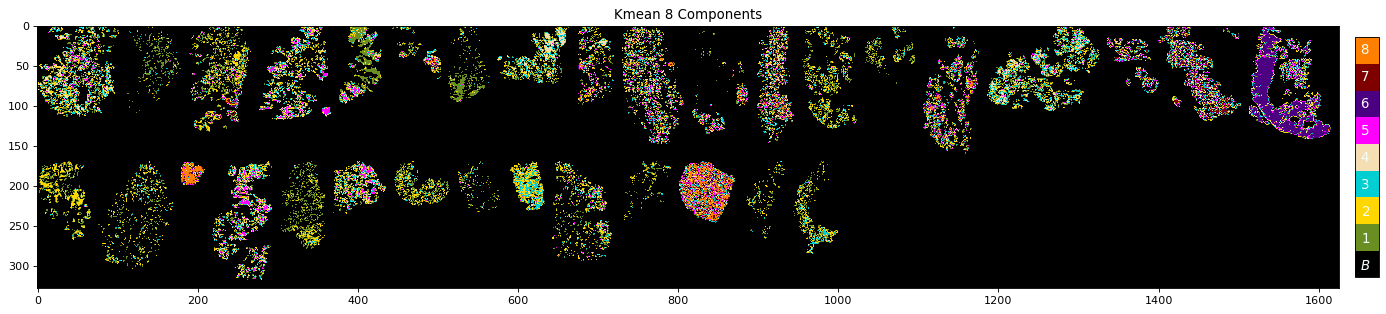

In [25]:

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 8 Components")
plt.imshow(KMeans_image, cmap=cmap8)

cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$','$6$','$7$','$8$']):
    cbar.ax.text(2.5, (j * 4.5 - 3.1) / 5, lab, ha='center', va='center', color="mintcream", fontsize=12, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D


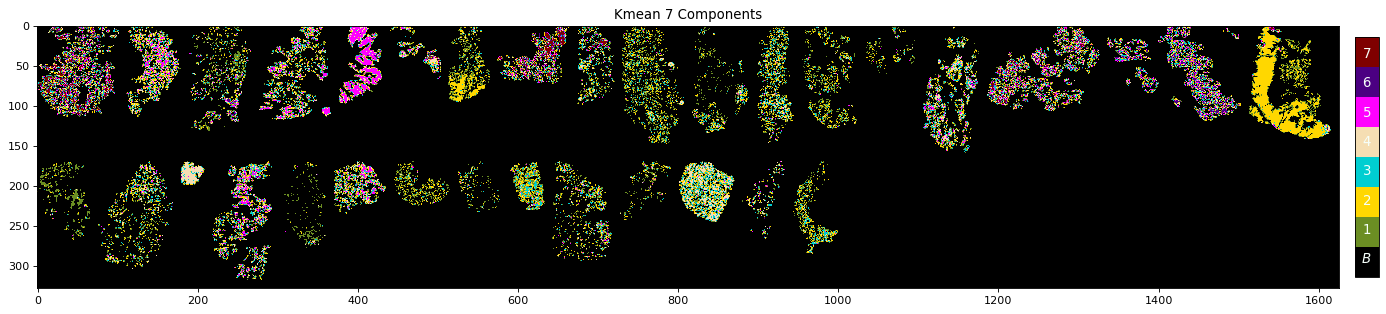

In [26]:

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 7 Components")
plt.imshow(KMeans_image_7, cmap=cmap7)

cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$','$6$','$7$']):
    cbar.ax.text(2.5, (j * 4.2 - 2.4) / 4.9, lab, ha='center', va='center', color="mintcream", fontsize=12, fontweight="extra bold", fontfamily="serif" ) # the font doesn't acutally change, only the size & color :D



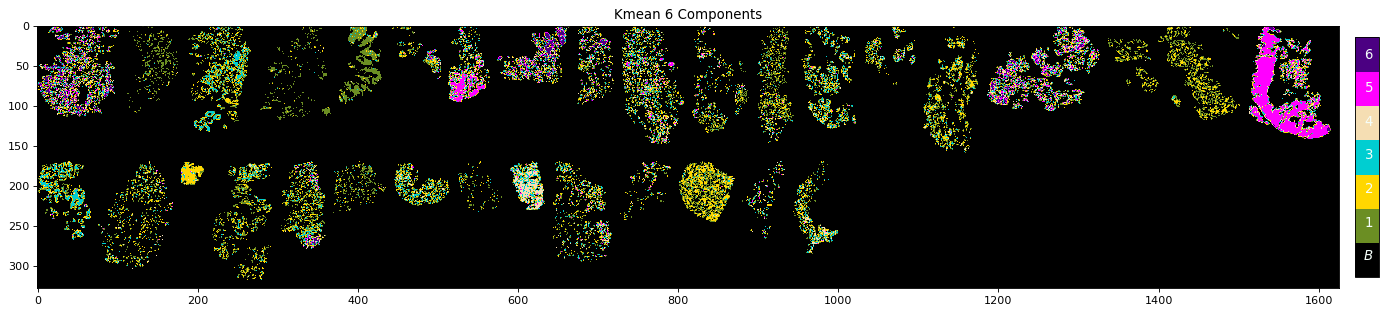

In [27]:

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 6 Components")
plt.imshow(KMeans_image_6, cmap=cmap6)

cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$','$6$']):
    cbar.ax.text(2.5, (j * 4.2 - 2.4) / 5, lab, ha='center', va='center', color="mintcream", fontsize=12, fontweight="extra bold", fontfamily="serif" ) # the font doesn't acutally change, only the size & color :D



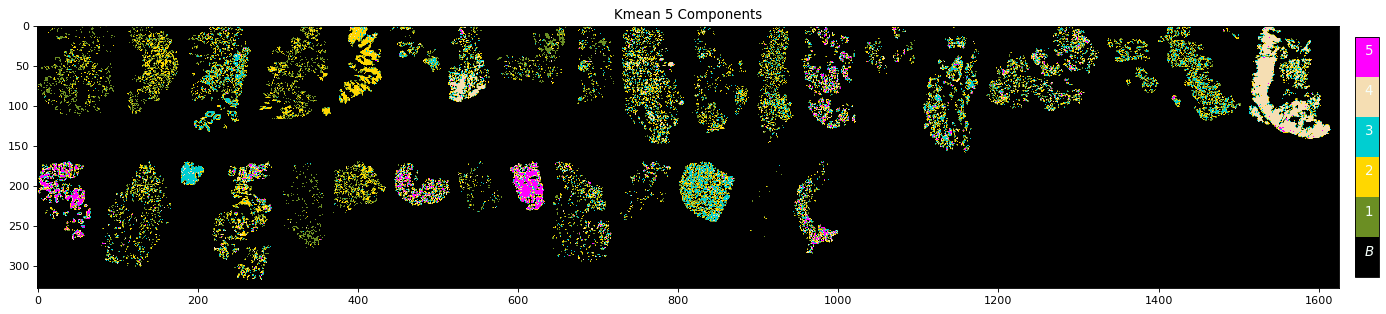

In [28]:

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 5 Components")
plt.imshow(KMeans_image_5, cmap=cmap5)

cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$']):
    cbar.ax.text(2, (j * 4.2 - 2.4) / 5, lab, ha='center', va='center', color="mintcream", fontsize=12, fontweight="extra bold", fontfamily="serif" ) # the font doesn't acutally change, only the size & color :D



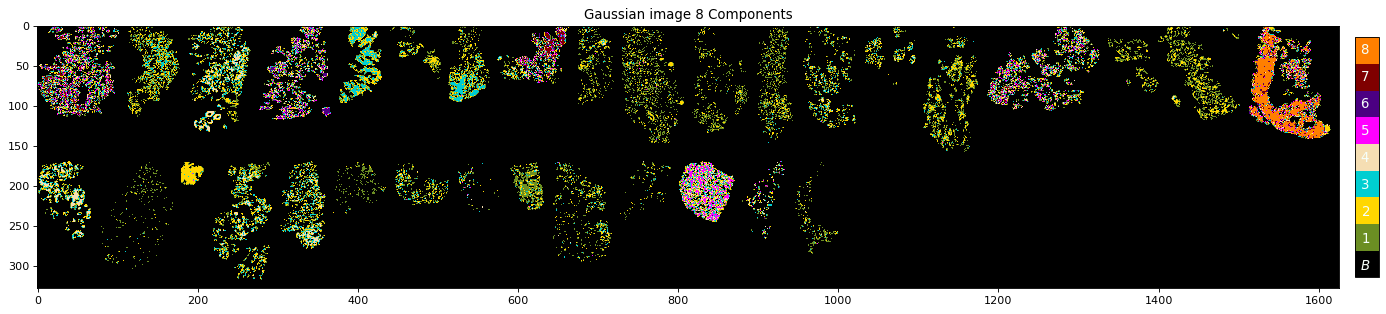

In [29]:

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Gaussian image 8 Components")
plt.imshow(gaussian_image, cmap=cmap8)

cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$','$6$','$7$','$8$']):
    cbar.ax.text(2.5, (j * 4.5 - 3.1) / 5, lab, ha='center', va='center', color="mintcream", fontsize=12, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D


# Zoomedin image Results

In [30]:
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 21, PixelSampleID = pixel_to_sample_ID , padding_factor = 2)

zoomedIn_image = KMeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


zoomedIn_image_5 = KMeans_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


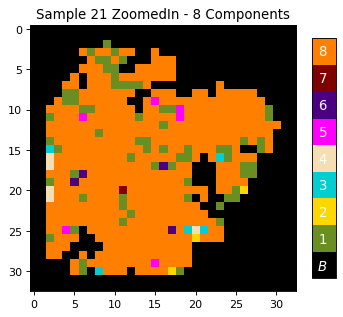

In [31]:

'''
unique_cluster_labels = np.unique(zoomedIn_image)
colorarray8_np = np.array(colorarray8)
zoomedin_cmap = CreateColorMap(len(unique_cluster_labels) , colorarray8_np[unique_cluster_labels+1])

x = np.arange(-1,len(unique_cluster_labels))
iterations = len(x) - len(unique_cluster_labels)
for i in range(iterations):
    x = np.delete(x, -1)
print(x)

plt.imshow(zoomedIn_image, cmap=zoomedin_cmap)
colorbar = plt.colorbar()
colorbar.set_ticks(x)
colorbar.set_ticklabels(labels[unique_cluster_labels+1])
'''

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Sample 21 ZoomedIn - 8 Components")
plt.imshow(zoomedIn_image, cmap=cmap8)

cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$','$6$','$7$','$8$']):
    cbar.ax.text(2.5, (j * 4.5 - 3.1) / 5, lab, ha='center', va='center', color="mintcream", fontsize=12, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D







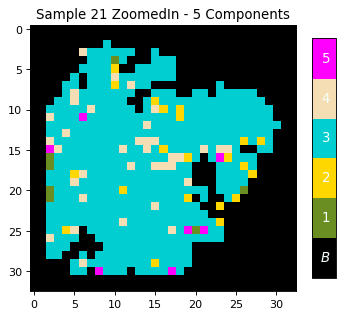

In [32]:

'''
unique_cluster_labels = np.unique(zoomedIn_image)
colorarray8_np = np.array(colorarray8)
zoomedin_cmap = CreateColorMap(len(unique_cluster_labels) , colorarray8_np[unique_cluster_labels+1])

x = np.arange(-1,len(unique_cluster_labels))
iterations = len(x) - len(unique_cluster_labels)
for i in range(iterations):
    x = np.delete(x, -1)
print(x)

plt.imshow(zoomedIn_image, cmap=zoomedin_cmap)
colorbar = plt.colorbar()
colorbar.set_ticks(x)
colorbar.set_ticklabels(labels[unique_cluster_labels+1])
'''

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Sample 21 ZoomedIn - 5 Components")
plt.imshow(zoomedIn_image_5, cmap=cmap5)

cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$']):
    cbar.ax.text(1.8, (j * 4.5 - 3.1) / 5.4, lab, ha='center', va='center', color="mintcream", fontsize=12, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D


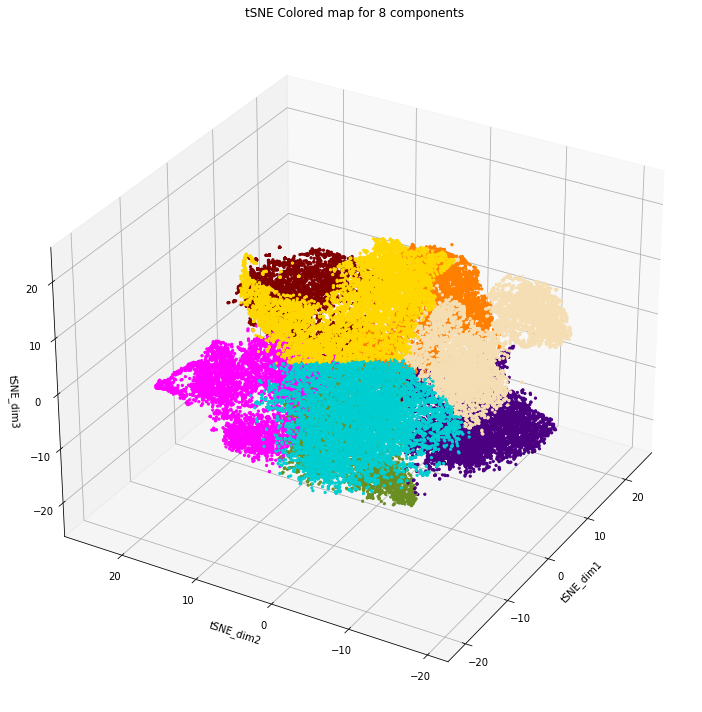

In [33]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = kmeans.labels_,
    cmap = cmapTSNE,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Colored map for 8 components")


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

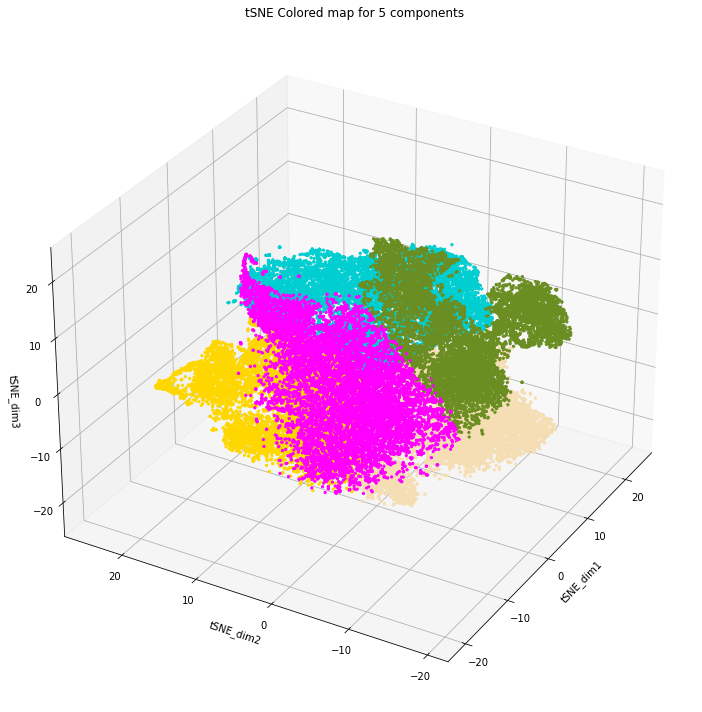

In [34]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = kmeans_5.labels_,
    cmap = cmap5_TSNE,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Colored map for 5 components")


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

# Metastasis Analysis

In [35]:
Clinical_data = pd.read_excel('ClinicalData.xlsx',"Breast Cancer Clinical Data")
# print(Clinical_data["pN"])

In [36]:
def metastasis_status(labels, Clinical_data, sample_ID_pixels=sample_ID_pixels):

    Clinical_data_copied = Clinical_data.copy(deep=True)
    labels_count = len(np.unique(labels))
    Clusters = [[] for _ in range(labels_count)]

    for i in range(1,len(Clinical_data)+1):
        Pixels_Samples = np.where(sample_ID_pixels == i)[0]
        Patient_Labels = labels[Pixels_Samples]

        for cluster_label in range(labels_count):
            Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]
            if len(Patient_Pixels) >= int((1/labels_count * len(Patient_Labels))):
                Clusters[cluster_label].append(i)

    NonMetastasis_Clusters = [[] for _ in range(labels_count)]
    Metastasis_Clusters = [[] for _ in range(labels_count)]
    Metastasis_IDs = [[] for _ in range(labels_count)]

    patient_id_iterator = 1
    for i in range(0, len(Clinical_data)):
        for j in range(labels_count):
            if (patient_id_iterator in Clusters[j]):
                if Clinical_data["pN"][i] == 1:
                    NonMetastasis_Clusters[j].append(1)
                elif Clinical_data["pN"][i] == 2:
                    Metastasis_Clusters[j].append(1)
                    Metastasis_IDs[j].append(patient_id_iterator)
        patient_id_iterator += 1


    return NonMetastasis_Clusters, Metastasis_Clusters



In [37]:
def plot_metastasis_status(state0, state1):
   ind = len(state0)
   status0 = np.zeros(ind)
   status1 = np.zeros(ind)
   cluster_numbers = []
   for i in range(1, ind+1):
      cluster_numbers.append(str(i))
      

   for i in range(len(state0)):
      status0[i] = len(state0[i])
   for i in range(len(state1)):
      status1[i] = len(state1[i])
   print("NonMetastasis: " + str(status0))
   print("Metastasis: " + str(status1))

   plt.bar(cluster_numbers, status0, color="#d4d0c8")
   plt.bar(cluster_numbers, status1, bottom=status0, color="black")
   plt.xticks(cluster_numbers)
   plt.xlabel("Cluster numbers")
   plt.ylabel("Number of patients")
   plt.title("Metastasis Analysis of {} Clusters".format(ind))
   colors = {'pN0': '#d4d0c8', 'pN1': 'black'}
   labels = list(colors.keys())
   handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label])
              for label in labels]
   plt.legend(handles, labels)

   plt.show()


NonMetastasis: [6. 1. 0. 4. 2. 1. 2. 4.]
Metastasis: [ 2.  6. 12.  4.  3.  1.  3.  5.]


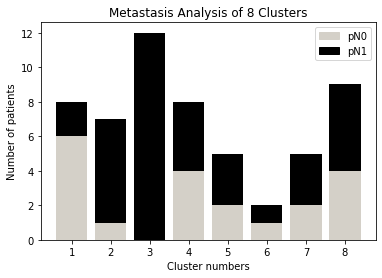

NonMetastasis: [1. 3. 0. 4. 4. 2. 4.]
Metastasis: [ 6.  1. 12.  5.  5.  3.  3.]


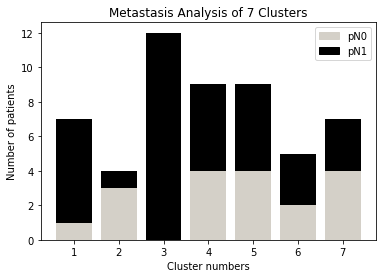

NonMetastasis: [4. 3. 1. 0. 3. 4.]
Metastasis: [ 5.  5.  7. 11.  1.  5.]


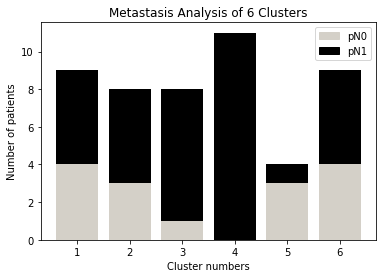

NonMetastasis: [4. 4. 4. 3. 0.]
Metastasis: [ 5.  4.  6.  1. 13.]


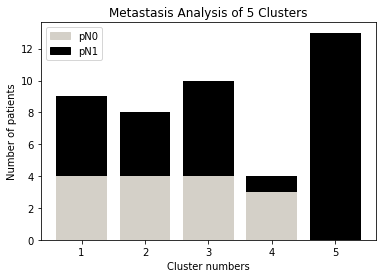

In [38]:
# Returns Non-Metastasis and Metastasis clusters
state08, state18 = metastasis_status(kmeans.labels_, Clinical_data)
state07, state17 = metastasis_status(kmeans_7.labels_, Clinical_data)
state06, state16 = metastasis_status(kmeans_6.labels_, Clinical_data)
state05, state15 = metastasis_status(kmeans_5.labels_, Clinical_data)
# gmm08,gmm18=metastasis_status(gmm,Clinical_data)
#state09,state19=metastasis_status(kmeans_9.labels_,Clinical_data)

# Plots bar plot of Non-Metastasis and Metastasis clusters
plot_metastasis_status(state08, state18)
plot_metastasis_status(state07, state17)
plot_metastasis_status(state06, state16)
plot_metastasis_status(state05, state15)
# plot_metastasis_status(gmm08,gmm18)
#plot_metastasis_status(state09,state19)


# Fisher Exact Test


In [39]:
'''
#table, column fully metastatic cluster, column not fully metastatic cluster
#row 1:               number of metastasis, number of metastasis 
#row 2:               number of non-metastasis, number of non-metastasis
ind = len(state08)
status0 = np.zeros(ind)
status1 = np.zeros(ind)

for i in range(len(state08)):
    status0[i] = len(state08[i])
for i in range(len(state18)):
    status1[i] = len(state18[i])

metastatic_cluster_N0 = 0
metastatic_cluster_N1 = status1[fully_metastasis_cluster_label]

new_status_0 = np.delete(status0,fully_metastasis_cluster_label)
non_metastatic_cluster_N0 = sum(new_status_0)

new_status_1 = np.delete(status1,fully_metastasis_cluster_label)
non_metastatic_cluster_N1 = sum(new_status_1)

table = np.array([[metastatic_cluster_N1 , non_metastatic_cluster_N1] , [metastatic_cluster_N0 , non_metastatic_cluster_N0 ]])
M = table.sum()
n = table[0].sum()
N = table[:, 0].sum()
start, end = hypergeom.support(M, n, N)
hypergeom.pmf(np.arange(start, end+1), M, n, N)

oddsr, p = fisher_exact(table, alternative='two-sided')
p
'''

"\n#table, column fully metastatic cluster, column not fully metastatic cluster\n#row 1:               number of metastasis, number of metastasis \n#row 2:               number of non-metastasis, number of non-metastasis\nind = len(state08)\nstatus0 = np.zeros(ind)\nstatus1 = np.zeros(ind)\n\nfor i in range(len(state08)):\n    status0[i] = len(state08[i])\nfor i in range(len(state18)):\n    status1[i] = len(state18[i])\n\nmetastatic_cluster_N0 = 0\nmetastatic_cluster_N1 = status1[fully_metastasis_cluster_label]\n\nnew_status_0 = np.delete(status0,fully_metastasis_cluster_label)\nnon_metastatic_cluster_N0 = sum(new_status_0)\n\nnew_status_1 = np.delete(status1,fully_metastasis_cluster_label)\nnon_metastatic_cluster_N1 = sum(new_status_1)\n\ntable = np.array([[metastatic_cluster_N1 , non_metastatic_cluster_N1] , [metastatic_cluster_N0 , non_metastatic_cluster_N0 ]])\nM = table.sum()\nn = table[0].sum()\nN = table[:, 0].sum()\nstart, end = hypergeom.support(M, n, N)\nhypergeom.pmf(np.aran

# SAM

In [40]:
# Detect the fully metastasis cluster
selected_state = state05
fully_metastasis_cluster_label = 0
labels = kmeans_5.labels_

for cluster in selected_state:
    if not cluster: # Cluster list is empty, has no healthy patients, so it's fully metastasis cluster
        break # fully_metastasis_cluster_label now has the right label, exit loop
    
    fully_metastasis_cluster_label += 1

print("Fully metastasis cluster label's index is {} and it is cluster {}".format(fully_metastasis_cluster_label,fully_metastasis_cluster_label+1))

Fully metastasis cluster label's index is 4 and it is cluster 5


In [41]:
labels_count=len(np.unique(labels))
indices_of_patients = [[] for _ in range(len(Clinical_data))]
Sig_Cluster=[[] for _ in range(len(Clinical_data))]
Status=[[] for _ in range(len(Clinical_data))]

for i in range(1,len(Clinical_data)+1):
    Pixels_Samples = np.where(sample_ID_pixels == i)[0]
    Patient_Labels = labels[Pixels_Samples]
    
    for cluster_label in range(labels_count):

        Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]

        if len(Patient_Pixels) >= int((1/labels_count * len(Patient_Labels))):

            if cluster_label != fully_metastasis_cluster_label:
                
                Status[i-1].append(1)
            else:
                Status[i-1].append(2)  


            Sig_Cluster[i-1].append(cluster_label)

    for j in range(0,len(Sig_Cluster[i-1])):
        
        indices=np.where(labels == Sig_Cluster[i-1][j])[0]

        # for element in indices:
        #     if element in Pixels_Samples:
                
        #         indices_of_patients[i-1].append(element)

        indices_of_patients[i-1].extend(list(set(Pixels_Samples).intersection(indices)))


In [42]:
Final_Status=[]
for patient in Status:
    if 2 in patient:
        Final_Status.append(2)
    else:
        Final_Status.append(1)

In [43]:
Unique_IDs = list(range(1,len(Clinical_data)+1))
Metastasis_Patients = [ ]
Average_protein_values = [ ]

for i in range(0,len(Unique_IDs)):
    Patient_MSI_values = sample_only_data[indices_of_patients[i]]
    Metastasis_Patients.append(Patient_MSI_values)
    Average_protein_values.append(np.average(Metastasis_Patients[i], axis=0))
    

In [44]:
protein_dataframe = pd.DataFrame(Average_protein_values,columns=peak_list[:,0].astype(int))
protein_dataframe["Status"] = Final_Status
# protein_dataframe["SampleID"] = np.arange(1,len(Clinical_data)+1)

In [45]:
protein_dataframe

,2479,3002,3326,3370,3444,3483,4025,4620,4745,4788,...,15872,17091,20737,20775,20973,21280,21781,22265,22491,Status
0,0.001356,0.000841,0.001339,0.000669,0.001194,0.000793,0.015617,0.001509,0.004385,0.003069,...,0.003198,0.000848,0.001188,0.001355,0.000602,0.000760,0.002365,0.000698,0.001895,1
1,0.002272,0.001143,0.000995,0.000705,0.002137,0.001759,0.001583,0.000817,0.002237,0.001492,...,0.000579,0.000432,0.000910,0.001062,0.000577,0.000777,0.001639,0.000422,0.000776,1
2,0.001331,0.001508,0.001259,0.000861,0.001149,0.001035,0.000918,0.001337,0.004959,0.002461,...,0.000980,0.000531,0.000612,0.000659,0.000556,0.001255,0.001941,0.000999,0.002053,1
3,0.001972,0.001195,0.003400,0.000797,0.001303,0.001009,0.001337,0.001784,0.019394,0.007519,...,0.000657,0.000447,0.000681,0.000813,0.000477,0.001108,0.001784,0.000699,0.001015,1
4,0.002291,0.001731,0.001555,0.000768,0.001302,0.001255,0.001161,0.001253,0.005211,0.003375,...,0.000598,0.000481,0.001033,0.001410,0.000755,0.000818,0.001551,0.000477,0.001084,1
5,0.001800,0.002388,0.005561,0.002077,0.001714,0.002065,0.005169,0.001246,0.003231,0.001920,...,0.002241,0.000594,0.001391,0.001631,0.000855,0.001134,0.001499,0.000730,0.001337,1
6,0.002527,0.001264,0.000974,0.000667,0.001418,0.001428,0.001261,0.001168,0.002190,0.001396,...,0.000650,0.000542,0.001044,0.001081,0.000679,0.000871,0.001303,0.000698,0.001268,1
7,0.001114,0.000950,0.000994,0.000877,0.001200,0.001166,0.004380,0.000876,0.001068,0.000948,...,0.001366,0.000632,0.000963,0.001001,0.000808,0.000798,0.001137,0.000606,0.000841,1
8,0.001131,0.000995,0.000952,0.000639,0.001070,0.000991,0.000998,0.000559,0.001907,0.001338,...,0.001746,0.000593,0.001153,0.001197,0.000798,0.000742,0.001303,0.000610,0.001104,1
9,0.001294,0.001022,0.000839,0.000659,0.001132,0.001151,0.003134,0.000921,0.001113,0.000975,...,0.000869,0.000658,0.001496,0.001851,0.001134,0.000972,0.001755,0.000700,0.001415,1


In [46]:
protein_dataframe.to_csv("BreastCancerAverageSpectrumValues.csv",index=False)

In [47]:
protein_ion = 4965
protein_index = protein_dataframe.columns.get_loc(protein_ion)
print(protein_index)

11


In [48]:
scaler = MinMaxScaler(feature_range=(-1,1))

Scaled_MSI_Protein_Values = scaler.fit_transform(MSI_data_cube[:,:,protein_index]) 

In [49]:
# np.unique(MSI_data_cube[:,:,protein_index])[1]
protein_arr = copy.deepcopy(MSI_data_cube[:,:,protein_index])
#protein_arr = copy.deepcopy(Scaled_MSI_Protein_Values)

mask = (MSI_data_cube[:,:,protein_index] == 0)
#mask = (Scaled_MSI_Protein_Values == -1) 

protein_arr[mask]= 0

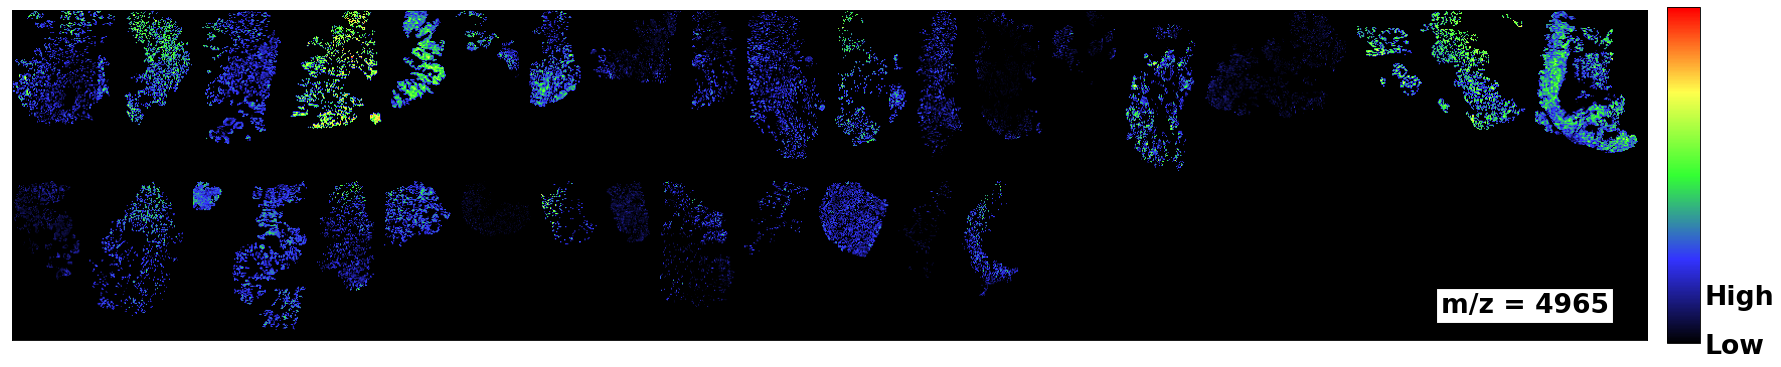

In [50]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


colorarray=["black",adjust_lightness("blue",1.2),adjust_lightness("lime",1.2),adjust_lightness("yellow",1.3),adjust_lightness("red",1)]
cmap = CreateColorMap_Continuous(len(colorarray)+1,colorarray)

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.imshow(protein_arr,cmap)
colorbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)
max_tick = 0.026 # variable to be edited for max tick

colorbar.ax.tick_params(size=0)
colorbar.set_ticks([0,max_tick]) # Comment the colorbar lines and look at the tick values to find the max value tick to be edited
colorbar.ax.set_yticklabels(['Low','High'],weight='bold',fontsize=24) 
plt.text(1420,300, "{}{}".format("m/z = ", protein_ion) , fontsize = 24,fontweight="bold",bbox = dict(facecolor = 'white', alpha = 1))
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()


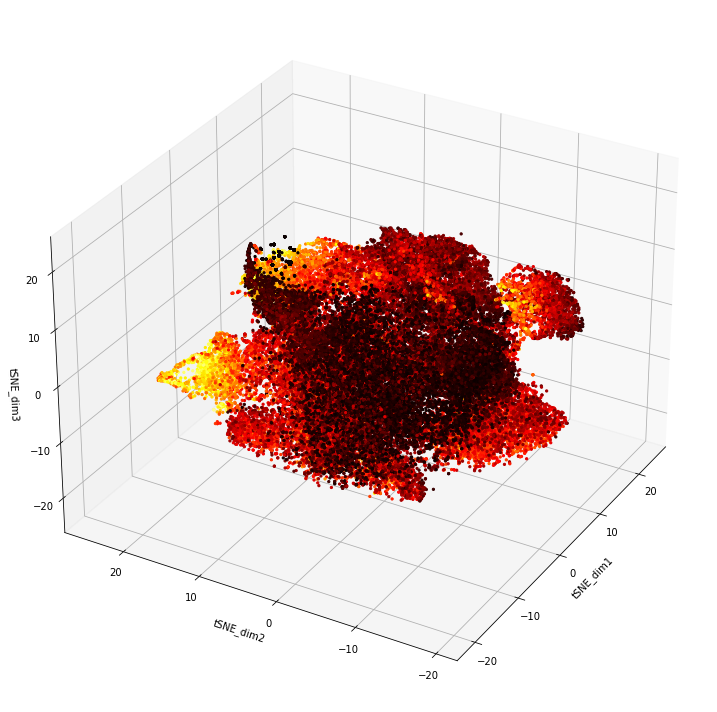

In [51]:
cmhot = plt.get_cmap("hot") #name of cmap u want from matplotlib

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = sample_only_data[:,protein_index],
    cmap = cmhot,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

# Classifier


In [52]:
SAM_protein= [6980,4999,7009,4965,11652,6277,5067,6650,9265,11310,5171]

In [53]:
SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

In [54]:
labels=kmeans_5.labels_
Fully_Metastasis_cluster=4
Non_Metastasis = 1
Metastasis = 2

labels_count=len(np.unique(labels))
Status=[[] for _ in range(len(Clinical_data))]

dropped_patient = -1

for i in range(1,len(Clinical_data)+1):

    if i == dropped_patient:
        break

    Pixels_Samples = np.where(sample_ID_pixels == i)[0]
    Patient_Labels = labels[Pixels_Samples]
    
    for cluster_label in range(labels_count):

        Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]

        if len(Patient_Pixels) >= int((1/labels_count * len(Patient_Labels))):

            if cluster_label != Fully_Metastasis_cluster:
                
                Status[i-1].append(1)
            else:
                Status[i-1].append(2)  



In [55]:
Final_Status=[]
for patient in Status:
    if 2 in patient:
        Final_Status.append(2)
    else:
        Final_Status.append(1)

In [56]:
Target_labels=copy.deepcopy(labels)

for i in range(1,len(Final_Status)+1):
    if Final_Status[i-1] == 2:

        Pixels_Samples = np.where(sample_ID_pixels == i)[0]
        Target_labels[Pixels_Samples] = Metastasis
    
Target_labels[Target_labels != Metastasis] = Non_Metastasis

In [57]:
test_patient_indicies=np.where(sample_ID_pixels == 15)

mask = np.ones(sample_only_scaled_data.shape[0], dtype=bool)
mask[test_patient_indicies] = False

train_data= sample_only_scaled_data[mask]
test_data= sample_only_scaled_data[test_patient_indicies]

train_labels=Target_labels[mask]
test_labels=Target_labels[test_patient_indicies]


train_data= train_data[:,SAM_protein_indices]
test_data= test_data[:,SAM_protein_indices]

In [58]:
#SVM Model

from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_data, train_labels)

#Predict the response for test dataset
y_pred = clf.predict(test_data)

In [ ]:
Propability_arr=np.unique(y_pred,return_counts=True)

In [ ]:
Total_Propability= sum(Propability_arr[1])
Metastasis_prob= (Propability_arr[1][0]/Total_Propability ) * 100
Non_Metastasis_prob= (Propability_arr[1][1] / Total_Propability ) * 100

In [ ]:
Metastasis_prob

59.94079921065614

In [ ]:
Non_Metastasis_prob

40.059200789343855

In [ ]:
######    KNN Model ######

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model.fit(train_data,train_labels)

KNeighborsClassifier()

In [ ]:
predicted_labels= model.predict(test_data)

In [ ]:
Propability_arr=np.unique(predicted_labels,return_counts=True)

In [ ]:
Total_Propability= sum(Propability_arr[1])
Metastasis_prob= (Propability_arr[1][0]/Total_Propability ) * 100
Non_Metastasis_prob= (Propability_arr[1][1] / Total_Propability ) * 100

In [ ]:
Metastasis_prob

52.04736063147508

In [ ]:
Non_Metastasis_prob

47.95263936852491